# Dataset: Light Pressure Coefficient & Radius of Perigee (grid)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Data

In [2]:
df_train = pd.read_csv("data/train_LPC_RP.csv", index_col="id")
df_test = pd.read_csv("data/test_LPC_RP.csv", index_col="id")
df_test_ans = pd.read_csv("data/ans_LPC_RP.csv", index_col="id")
df_test_ans['sat_id'] = df_test['sat_id']

n_sat = len(pd.unique(df_train["sat_id"]))

# Updated SGP4 prediction

Updated SGP4-model predictions where the last known true position point is used as the reference point.

In [3]:
from utils import sgp4_ephemeris

In [4]:
df_test_upd = pd.DataFrame().reindex_like(df_test)
df_test_upd[["sat_id", "epoch"]] = df_test[["sat_id", "epoch"]]

for sat_id in pd.unique(df_train["sat_id"]):
    ref_coords = df_train[df_train['sat_id'] == sat_id].iloc[-1]
    prediction_dates_list = df_test_upd[df_test_upd['sat_id'] == sat_id]['epoch']
    sgp4_upd = sgp4_ephemeris(ref_coords, prediction_dates_list)
    sgp4_upd.set_index(df_test_upd[df_test_upd['sat_id'] == sat_id].index, inplace=True)
    df_test_upd.loc[df_test_upd['sat_id'] == sat_id, ["x_sim", "y_sim", "z_sim", "Vx_sim", "Vy_sim", "Vz_sim"]] = sgp4_upd.drop(columns=["epoch"]).values

df_test_upd.head()

,sat_id,epoch,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
id,,,,,,,,
7708,0,2014-02-01T00:03:49.583,3186.446216,-9204.596797,7.418688,5.710653,2.097403,-0.012990
7709,0,2014-02-01T00:09:37.096,5070.672741,-8241.833704,2.748801,5.082647,3.422983,-0.013763
7710,0,2014-02-01T00:15:24.609,6685.647261,-6842.477889,-2.065747,4.163769,4.600308,-0.013814
7711,0,2014-02-01T00:21:12.122,7933.291561,-5068.423936,-6.764690,2.972752,5.568748,-0.013091
7712,0,2014-02-01T00:26:59.635,8723.833249,-3003.781905,-11.070960,1.539644,6.260993,-0.011550


In [5]:
# df_test_upd.to_csv('data/test_LPC_RP_updated_sgp4.csv')

# LR

In [6]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm

In [7]:
# features columns 
feature_cols = ["x_sim", "y_sim", "z_sim", "Vx_sim", "Vy_sim", "Vz_sim"]

# target variables columns 
target_cols = ["x", "y", "z", "Vx", "Vy", "Vz"]

### test dataset – SGP4 predictions

In [8]:
# Linear (Polynomial) Regression models
poly = PolynomialFeatures(2)

pred_lr = pd.DataFrame(columns=target_cols, index=df_test.index)
pred_lr["sat_id"] = df_test["sat_id"]

for sat_id in tqdm(range(n_sat)):
    
    train_idxs = df_train["sat_id"] == sat_id
    test_idxs = df_test["sat_id"] == sat_id
    X_train = df_train.loc[train_idxs, feature_cols]
    y_train = df_train.loc[train_idxs, target_cols]
    X_test = df_test.loc[test_idxs, feature_cols]
    
    model = LinearRegression(normalize=True).fit(X_train.values, y_train.values) 
    pred_lr.loc[test_idxs, target_cols] = model.predict(X_test.values)

100%|██████████| 225/225 [00:56<00:00,  3.32it/s]


### test dataset – updated SGP4 predictions

In [9]:
# Linear (Polynomial) Regression models
poly = PolynomialFeatures(2)

pred_lr_upd = pd.DataFrame(columns=target_cols, index=df_test.index)
pred_lr_upd["sat_id"] = df_test["sat_id"]

for sat_id in tqdm(range(n_sat)):
    
    train_idxs = df_train["sat_id"] == sat_id
    test_idxs = df_test["sat_id"] == sat_id
    X_train = df_train.loc[train_idxs, feature_cols]
    y_train = df_train.loc[train_idxs, target_cols]
    X_test = df_test_upd.loc[test_idxs, feature_cols]
    
    model = LinearRegression(normalize=True).fit(X_train.values, y_train.values) 
    pred_lr_upd.loc[test_idxs, target_cols] = model.predict(X_test.values)

100%|██████████| 225/225 [00:54<00:00,  3.39it/s]


# IDAO

IDAO submissions (SGP4 and SGP4-updated)

In [10]:
# submissions directory
sub_dir = 'submissions/'
participants = [
    'LPC_RP_data_o_plomo',
#     'LPC_RP_david_sergey',
    'LPC_RP_alsetboost',
    'LPC_RP_veni_vidi_vici',
]

In [11]:
pred_idao = {}
pred_idao_upd = {}
for p in participants:
    print(p)
    pred_idao[p] = pd.read_csv(sub_dir + 'sub_' + p + '.csv', index_col='id')
    pred_idao[p]['sat_id'] = pred_lr['sat_id']
    pred_idao_upd[p] = pd.read_csv(sub_dir + 'sub_' + p + '_updated_sgp4.csv', index_col='id')
    pred_idao_upd[p]['sat_id'] = pred_lr['sat_id']

LPC_RP_data_o_plomo
LPC_RP_alsetboost
LPC_RP_veni_vidi_vici


# SGP4-predictions

In [12]:
df_pred_sgp4 = df_test.rename(columns=dict(zip(feature_cols, target_cols)))
df_pred_sgp4_upd = df_test_upd.rename(columns=dict(zip(feature_cols, target_cols)))

# Metrics

In [13]:
from metrics import smape_idao, idao_score, smape_new_vector_norm, mahalanobis_distance

In [14]:
def print_metrics(model_name, pred):
    print(f"\n{model_name}\n")
    print(f"IDAO score:  {idao_score(pred[target_cols], df_test_ans[target_cols])}")    
    print(f"SMAPE IDAO:  {smape_idao(pred[target_cols], df_test_ans[target_cols])}")    
    print(f"SMAPE new:   {smape_new_vector_norm(pred, df_test_ans)}")    
#     print(f"Mahalanobis: {mahalanobis_distance(pred, df_test_ans)}")

### SGP4

In [15]:
print("TOTAL SCORE")
print_metrics("SGP4", df_pred_sgp4)
print_metrics("LR", pred_lr)
for part, pred in pred_idao.items():
    print_metrics(part, pred)

TOTAL SCORE

SGP4

IDAO score:  37.324851755698354
SMAPE IDAO:  0.6267514824430165
SMAPE new:   0.39937790198419265

LR

IDAO score:  55.47998004668875
SMAPE IDAO:  0.4452001995331126
SMAPE new:   0.3145024431789336

LPC_RP_data_o_plomo

IDAO score:  84.78633720366511
SMAPE IDAO:  0.15213662796334887
SMAPE new:   0.12034785153708875

LPC_RP_alsetboost

IDAO score:  71.75312744274854
SMAPE IDAO:  0.2824687255725146
SMAPE new:   0.17220031261014032

LPC_RP_veni_vidi_vici

IDAO score:  77.28523056347325
SMAPE IDAO:  0.22714769436526744
SMAPE new:   0.13680063665527328


### Updated SGP4

In [16]:
print("TOTAL SCORE")
print_metrics("Updated SGP4", df_pred_sgp4_upd)
print_metrics("LR (Updated SGP4)", pred_lr_upd)
for part, pred in pred_idao_upd.items():
    print_metrics(part + " (Updated SGP4)", pred)

TOTAL SCORE

Updated SGP4

IDAO score:  76.74469607670514
SMAPE IDAO:  0.23255303923294857
SMAPE new:   0.17122228662490271

LR (Updated SGP4)

IDAO score:  43.371303568440354
SMAPE IDAO:  0.5662869643155964
SMAPE new:   0.707792079875552

LPC_RP_data_o_plomo (Updated SGP4)

IDAO score:  84.78633720366511
SMAPE IDAO:  0.15213662796334887
SMAPE new:   0.12034785153708875

LPC_RP_alsetboost (Updated SGP4)

IDAO score:  71.75312744274855
SMAPE IDAO:  0.2824687255725145
SMAPE new:   0.17220031261014032

LPC_RP_veni_vidi_vici (Updated SGP4)

IDAO score:  68.26886681112015
SMAPE IDAO:  0.31731133188879856
SMAPE new:   0.23829998111340148


# Graphs: metrics

In [17]:
# KSD == коэффециент светового давления (КСД) == LPCё
df = pd.read_csv('data/LPC_RP.csv', index_col=0)
KSD_list = pd.unique(df["KSD"])
RP_list = pd.unique(df["RP"])

In [18]:
def err(pred, ksd, rp, metric):
    sat_id = df[(df['KSD'] == ksd) & (df['RP'] == rp)]['sat_id'].values[0]
    p = pred[pred['sat_id'] == sat_id]
    a = df_test_ans[df_test_ans['sat_id'] == sat_id]
    if metric == "idao_score":
        return idao_score(p[target_cols], a[target_cols])
    elif metric == "smape_idao":
        return smape_idao(p[target_cols], a[target_cols])
    elif metric == "smape_new_vector_norm":
        return smape_new_vector_norm(p, a)
    elif metric == "mahalanobis_distance":
        return mahalanobis_distance(p, a)
    elif metric == "abs":
        return (p - a).abs()
    else:
        raise ValueError()

In [19]:
def plot_err(pred, pred_name, metric):
    plt.figure(figsize=(6,6))
    title = f'{pred_name}: {metric}'
    plt.title(title, fontsize=14)
    y_axis = True
    Z = np.empty((len(KSD_list), len(RP_list)))
    for i, ksd in enumerate(KSD_list):
        for j, rp in enumerate(RP_list):
            Z[len(KSD_list) - i - 1, j] = err(pred, ksd, rp, metric)
    im = plt.imshow(Z)
    plt.colorbar(im)
    plt.ylabel(f"КСД: {min(KSD_list):.2f} – {max(KSD_list):.2f} кв.м/кг")
    plt.xlabel(f"радиус перигея: {min(RP_list):.2f} – {max(RP_list):.2f} км")
    plt.xticks([])
    plt.yticks([])
#     plt.savefig(f"{title}.png")
    plt.show()

In [20]:
metric_list = [
    'smape_idao',
    "smape_new_vector_norm",
#     "mahalanobis_distance",
]
pred_dict = {
    "SGP4": df_pred_sgp4, 
    "LR": pred_lr,
    "LR (upd sgp4)": pred_lr_upd,
}
pred_dict.update(pred_idao)
pred_idao_upd.update(pred_idao)

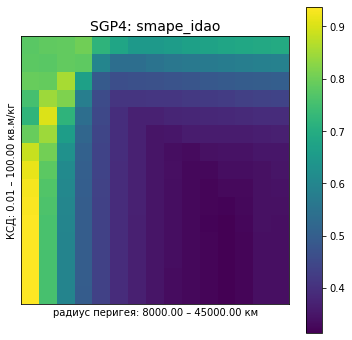

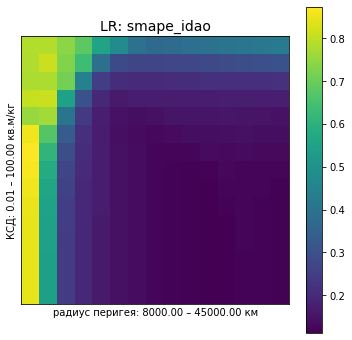

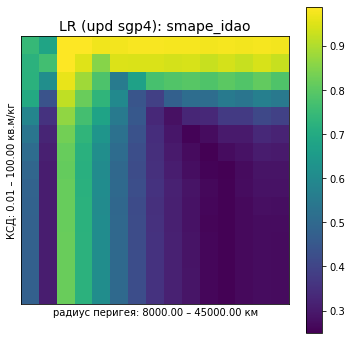

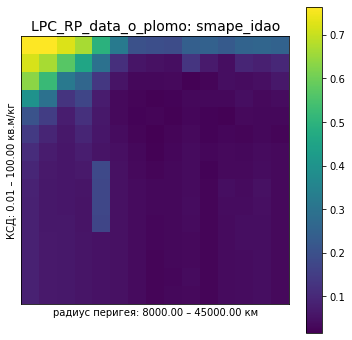

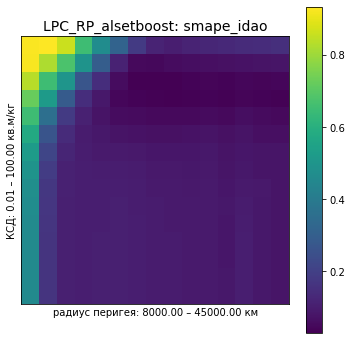

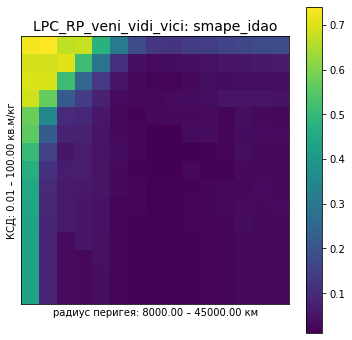

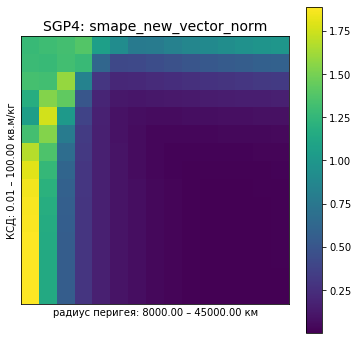

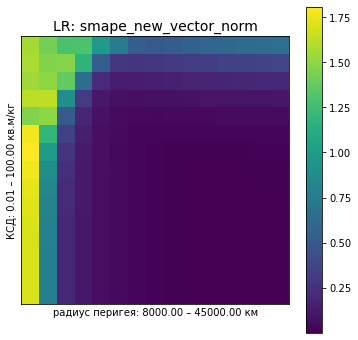

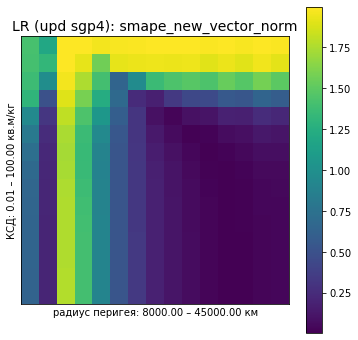

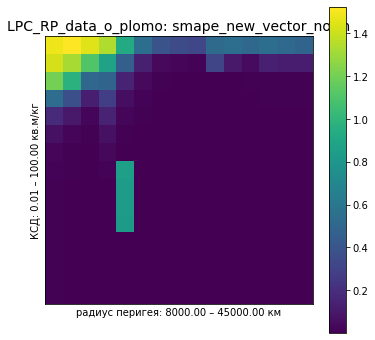

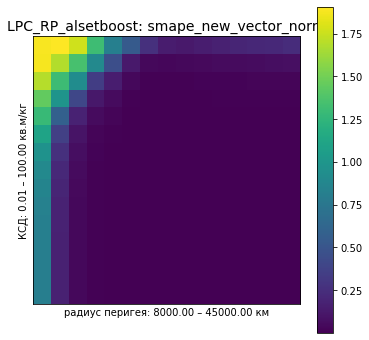

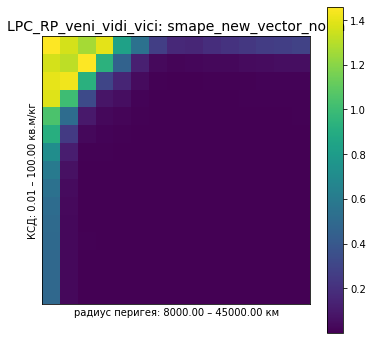

In [21]:
for metric in metric_list:
    for pred_name, pred in pred_dict.items():
        plot_err(pred=pred, pred_name=pred_name, metric=metric) 

# Graphs: abs error

In [22]:
# исключаем LR (upd sgp4), тк предсказания слишком не точные и мешают восприятию графиков
del pred_dict['LR (upd sgp4)']

In [23]:
def plot_graph_err_fixed_rp(pred_dict=pred_dict, ksd_graphs=list(KSD_list[::-5]) + [KSD_list[0]], rp=RP_list[6], coord='x'):
    for ksd in ksd_graphs: 
        plt.figure(figsize=(12,4))
        for pred_name, pred in pred_dict.items():
            plt.plot(err(pred, ksd, rp, metric="abs")[coord].values, alpha=0.6, label=pred_name)
        plt.grid()
        plt.xlabel('steps (1 месяц)')
        plt.ylabel('abs err (км)')
        title = f'abs err {coord}; КСД: {ksd:.2f} кв.м/кг; РП: {rp:.2f} км'
        plt.title(title)
        plt.legend()
#         plt.savefig(f"abs err {coord}; КСД: {ksd:.2f}; РП: {rp:.2f}.png")
        plt.show()

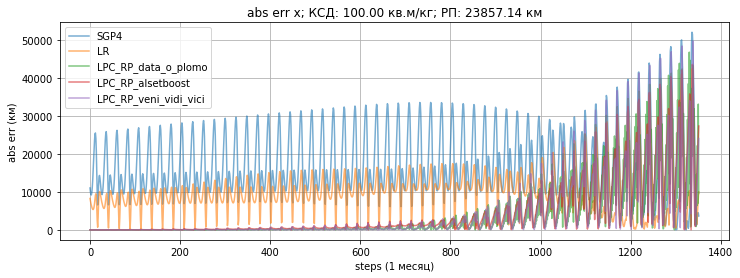

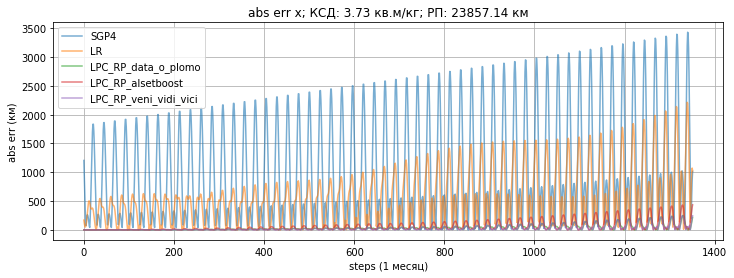

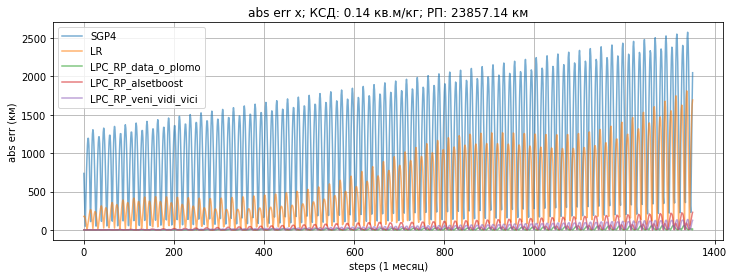

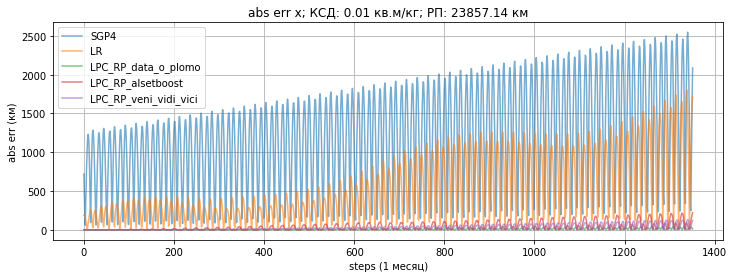

In [24]:
# для разных КСД при "среднем" РП
plot_graph_err_fixed_rp()

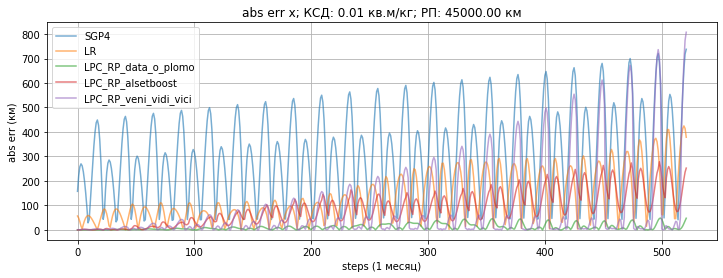

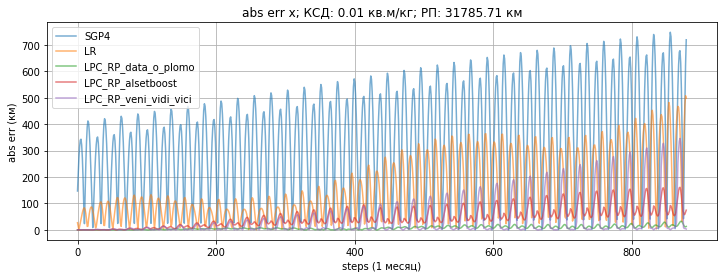

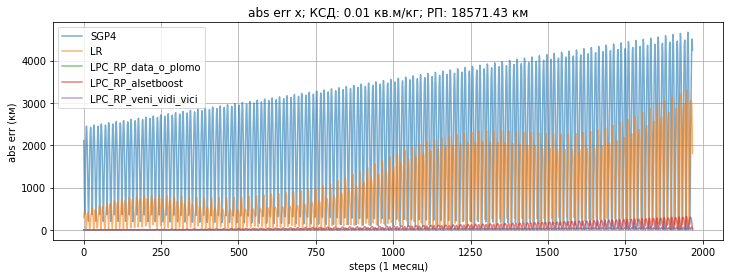

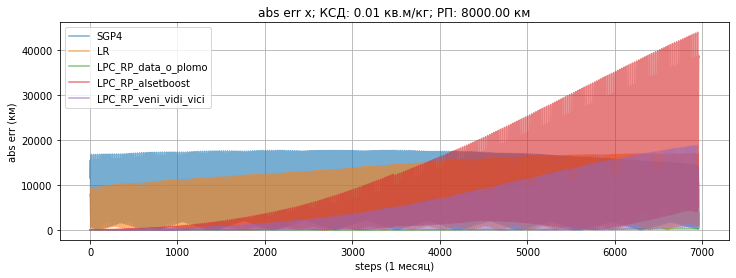

In [25]:
# для разных РП при "низком" КСД
def plot_graph_err_fixed_ksd(pred_dict=pred_dict, ksd=KSD_list[0], rp_graphs=list(RP_list[::-5]) + [RP_list[0]], coord='x'):
    for rp in rp_graphs: 
        plt.figure(figsize=(12,4))
        for pred_name, pred in pred_dict.items():
            plt.plot(err(pred, ksd, rp, metric="abs")[coord].values, alpha=0.6, label=pred_name)
        plt.grid()
        plt.xlabel('steps (1 месяц)')
        plt.ylabel('abs err (км)')
        title = f'abs err {coord}; КСД: {ksd:.2f} кв.м/кг; РП: {rp:.2f} км'
        plt.title(title)
        plt.legend()
#         plt.savefig(f"abs err {coord}; КСД: {ksd:.2f}; РП: {rp:.2f}.png")
        plt.show()

plot_graph_err_fixed_ksd()

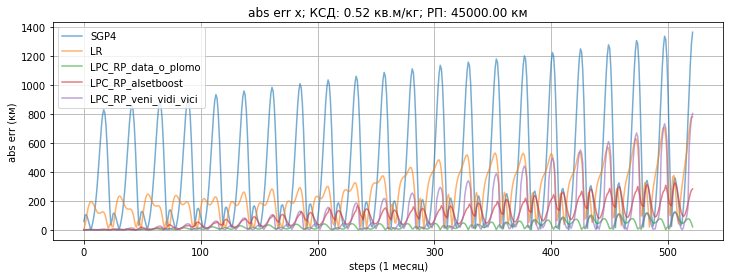

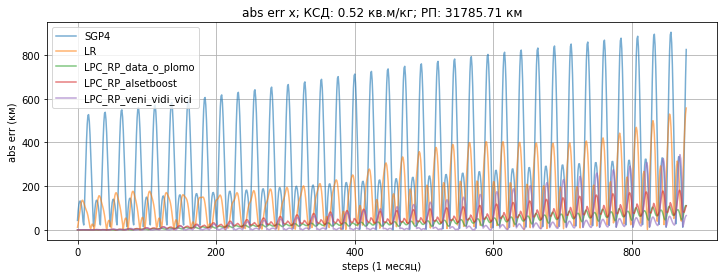

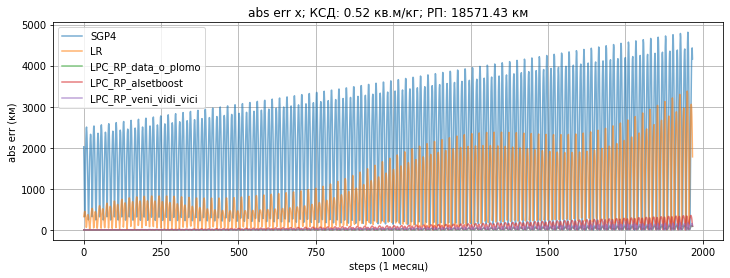

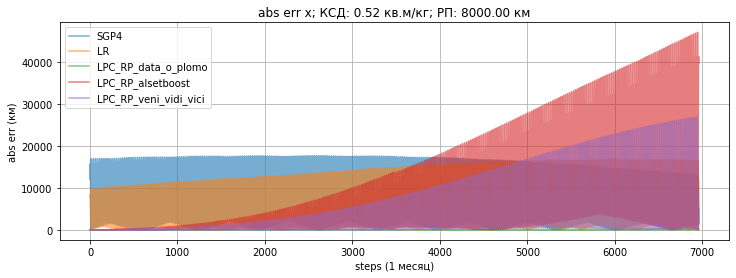

In [26]:
# для разных РП при "среднем" КСД
plot_graph_err_fixed_ksd(ksd=KSD_list[6], rp_graphs=list(RP_list[::-5]) + [RP_list[0]])

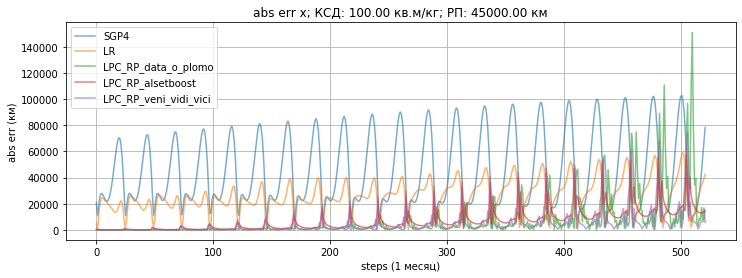

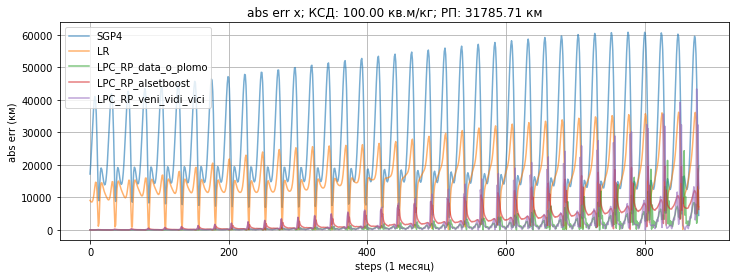

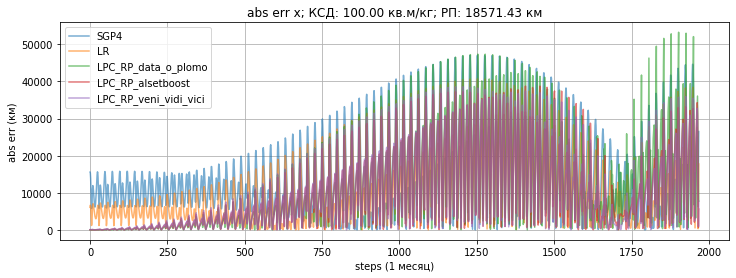

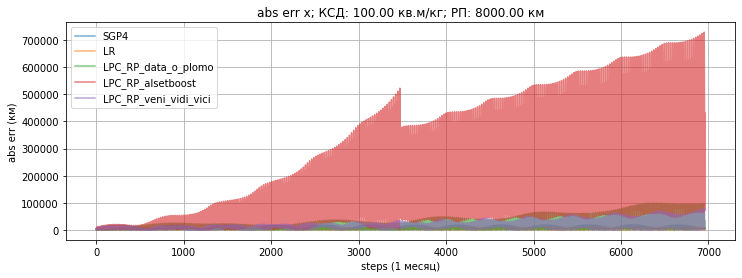

In [27]:
# для разных РП при "высоком" КСД
plot_graph_err_fixed_ksd(ksd=KSD_list[-1], rp_graphs=list(RP_list[::-5]) + [RP_list[0]])

# Conclusions

1. Using "Updated SGP4" doesn't improve models' score (?!)
1. High error at low Perigee Radius
2. IDAO models do quite well